<a href="https://colab.research.google.com/github/SCHAEDAV/CaseStudy_AI-/blob/main/Case_Study_v0_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install folktables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

In [ ]:
# Specify here which state and year the model should be trained (and tested) on
training_state = 'PA'
training_year = 2014
training_horizon = '1-Year'
# For task 6: Specify here in which state and when the model should be deployed
deployment_state = 'PA'
deployment_year = 2018
deployment_horizon = '1-Year'

# Setup

## Get training and testing data

In [ ]:
def preprocess_data(features, label, group):
  # Age
  ix_right_age_group = (features[:,0]>=25) & (features[:,0]<=65)
  features = features[ix_right_age_group]
  label = label[ix_right_age_group]
  group = group[ix_right_age_group]
  # Race
  ix_bw = (group==1) | (group==2)
  features = features[ix_bw]
  label = label[ix_bw]
  group = group[ix_bw]

  return (features, label, group)

In [ ]:
from folktables import ACSDataSource, ACSEmployment
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

data_source = ACSDataSource(survey_year=training_year, horizon=training_horizon, survey='person')
acs_data = data_source.get_data(states=[training_state], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
features, label, group = preprocess_data(features, label, group)

### How successful are the job coaches?
Base rate: Probability of finding employment within the first year of working with the job coaches

In [ ]:
np.mean(label)

0.710184182015168

## Train the model

In [ ]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Make predictions

In [ ]:
yhat = model.predict(X_test)
scores = model.predict_proba(X_test)[:,1]

# Task 1

In [ ]:
y_pred = (model.predict_proba(X_test)[:,1] >= 0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7649744621575607

In [ ]:
import numpy as np

bins = np.linspace(0, 1, 11)
binids = np.digitize(scores, bins)


In [ ]:
x = np.zeros(10)
y = np.zeros(10)
for i in range(10):
    x[i] = np.mean(scores[binids == i+1])
    y[i] = np.mean(y_test[binids == i+1])

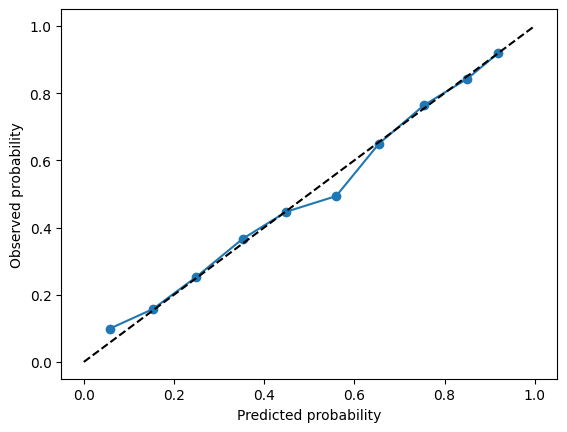

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y, 'o-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.show()

**Summary**


*   The graph should display both the predicted and actual probabilities along with 95% confidence intervals in the form of error bars.

*   Observing the calibration plot, it can be deduced that the model is not perfectly aligned as the predicted probabilities are generally higher than the actual probabilities, primarily for people with lower scores.
*   For the general observations once have to say that the model is moderately aligned since the predicted probabilities are relatively close to the actual probabilities.




 





# Task 2

In [ ]:
# Split test data by race
X_black = X_test[group_test == 1]
y_black = y_test[group_test == 1]
scores_black = model.predict_proba(X_black)[:, 1]

X_white = X_test[group_test == 2]
y_white = y_test[group_test == 2]
scores_white = model.predict_proba(X_white)[:, 1]




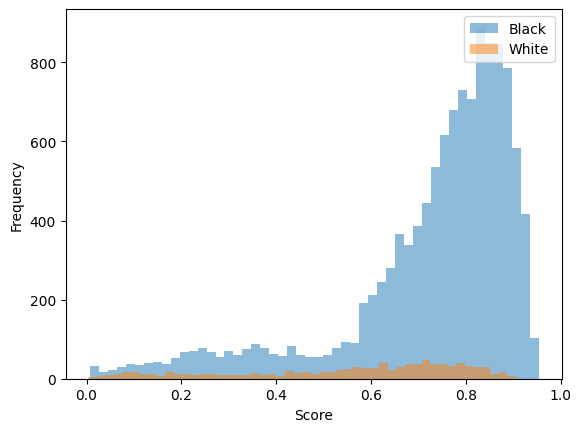

In [ ]:
#plot the distribution
import matplotlib.pyplot as plt

plt.hist(scores_black, bins=50, alpha=0.5, label='Black')
plt.hist(scores_white, bins=50, alpha=0.5, label='White')
plt.legend(loc='upper right')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

**Description of Results** tbd

Bin 3: statistically significant difference in reemployment rates (p=0.013)
Bin 4: statistically significant difference in reemployment rates (p=0.021)


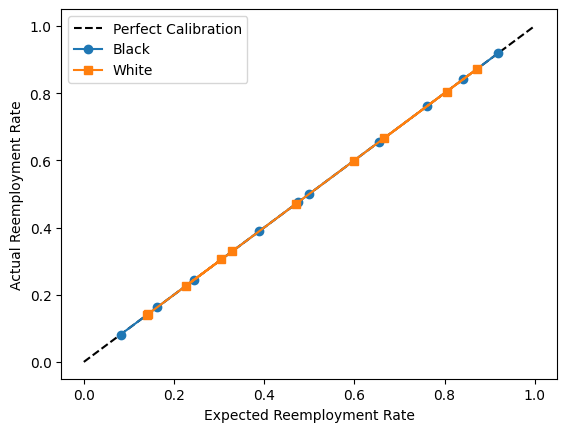

In [ ]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Split test data by race
X_black = X_test[group_test == 1]
y_black = y_test[group_test == 1]
scores_black = model.predict_proba(X_black)[:, 1]

X_white = X_test[group_test == 2]
y_white = y_test[group_test == 2]
scores_white = model.predict_proba(X_white)[:, 1]

# Define score bins
bins = np.arange(0, 1.1, 0.1)

# Calculate actual reemployment rates for each score bin for both groups
actual_rates_black, actual_rates_white = [], []
for i in range(len(bins) - 1):
    bin_mask_black = (scores_black >= bins[i]) & (scores_black < bins[i+1])
    bin_mask_white = (scores_white >= bins[i]) & (scores_white < bins[i+1])
    actual_rate_black = np.mean(y_black[bin_mask_black])
    actual_rate_white = np.mean(y_white[bin_mask_white])
    actual_rates_black.append(actual_rate_black)
    actual_rates_white.append(actual_rate_white)
    
    # Perform hypothesis test for each bin
    p_value = ttest_ind(y_black[bin_mask_black], y_white[bin_mask_white])[1]
    if p_value < 0.05:
        print(f"Bin {i}: statistically significant difference in reemployment rates (p={p_value:.3f})")
        
expected_rates_black = np.array(actual_rates_black)
expected_rates_white = np.array(actual_rates_white)

plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.plot(expected_rates_black, actual_rates_black, 'o-', label='Black')
plt.plot(expected_rates_white, actual_rates_white, 's-', label='White')
plt.xlabel('Expected Reemployment Rate')
plt.ylabel('Actual Reemployment Rate')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
for race_group in [1, 2]:
    ix_group_test = group_test == race_group
    group_y_test = y_test[ix_group_test]
    group_yhat = yhat[ix_group_test]

    group_accuracy = accuracy_score(group_y_test, group_yhat)
    group_confusion = confusion_matrix(group_y_test, group_yhat)

    print(f"Group {race_group} ({'White' if race_group == 1 else 'Black'}) accuracy:", group_accuracy)
    print(f"Group {race_group} ({'White' if race_group == 1 else 'Black'}) confusion matrix:\n", group_confusion)

Group 1 (White) accuracy: 0.7688896326667225
Group 1 (White) confusion matrix:
 [[ 987 2325]
 [ 437 8202]]
Group 2 (Black) accuracy: 0.7167868177136972
Group 2 (Black) confusion matrix:
 [[249 200]
 [ 75 447]]


In [ ]:
# Predict labels for black and white groups separately
y_pred_black = model.predict(X_test[group_test == 1])
y_pred_white = model.predict(X_test[group_test == 2])

# Calculate base rate
base_rate = np.mean(y_test)

# Calculate positive rate, true positive rate, false negative rate, false positive rate, and true negative rate for black group
pr_black = np.mean(y_pred_black)
tpr_black = np.mean(y_pred_black[y_black == 1])
fnr_black = np.mean(1 - y_pred_black[y_black == 1])
fpr_black = np.mean(y_pred_black[y_black == 0])
tnr_black = np.mean(1 - y_pred_black[y_black == 0])

# Calculate positive rate, true positive rate, false negative rate, false positive rate, and true negative rate for white group
pr_white = np.mean(y_pred_white)
tpr_white = np.mean(y_pred_white[y_white == 1])
fnr_white = np.mean(1 - y_pred_white[y_white == 1])
fpr_white = np.mean(y_pred_white[y_white == 0])
tnr_white = np.mean(1 - y_pred_white[y_white == 0])

print('Base Rate:', base_rate)
print('Positive Rate (Black):', pr_black)
print('Positive Rate (White):', pr_white)
print('True Positive Rate (Black):', tpr_black)
print('True Positive Rate (White):', tpr_white)
print('False Negative Rate (Black):', fnr_black)
print('False Negative Rate (White):', fnr_white)
print('False Positive Rate (Black):', fpr_black)
print('False Positive Rate (White):', fpr_white)
print('True Negative Rate (Black):', tnr_black)
print('True Negative Rate (White):', tnr_white)

Base Rate: 0.708945983593871
Positive Rate (Black): 0.8808467910635094
Positive Rate (White): 0.666323377960865
True Positive Rate (Black): 0.9494154416020373
True Positive Rate (White): 0.8563218390804598
False Negative Rate (Black): 0.05058455839796273
False Negative Rate (White): 0.14367816091954022
False Positive Rate (Black): 0.7019927536231884
False Positive Rate (White): 0.44543429844098
True Negative Rate (Black): 0.2980072463768116
True Negative Rate (White): 0.5545657015590201


**Description of Results**tbd
Code review (task 2, 3)

# Task 3

#### True Positive
- Save on the unemployment benefits cost for two years: 2 * 30'000 = 60'000
- Cost for the job coaching program: -20'000
- Utility: 60'000 -20'000 = 40'000

#### False Negative
- No cost saved on unemployment benefits
- No cost spend on job coaching
- Utility: 0

#### False Positive
- No cost saved on unemployment benefits
- Cost for the job coaching program: -20'000
- Utility: - 20'000

#### True Negative
- No cost saved on unemployment benefits
- No cost spend on job coaching
- Utility: 0

#### Decision maker utility matrix
| | Y=0 | Y=1 |
|-|-|-|
|D=0|0|0|
|D=1|-20'000|40'000|

In [ ]:
thresholds = np.arange(0, 1.01, 0.01)
max_utility = -np.inf
best_threshold = None

for threshold in thresholds:
    y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    
    # Calculate utility based on the utility matrix
    utility = np.sum((y_test == 1) & (y_pred == 1)) * 40000 - np.sum((y_test == 0) & (y_pred == 1)) * 20000
    
    if utility > max_utility:
        max_utility = utility
        best_threshold = threshold

print(f"Best threshold: {best_threshold}, Total utility: {max_utility}")

Best threshold: 0.36, Total utility: 299480000


# Task 4
Assumtions:
- Job coaching takes time and effort for the job seeker (-0.1) but also gives them knowledge that can be used in other areas (+0.3)
- Finding a Job improves the condition of job seeker (+0.8)

#### Decision subject utility matrix
| | Y=0 | Y=1 |
|-|-|-|
|D=0|0|0.8|
|D=1|0.2|1|

#### Fairness criterion
TPR(Black | J=j) = TPR(White | J=j)



In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# True Positive Rate comparison
TP_black = np.sum((y_black == 1) & (y_pred_black == 1))
TP_white = np.sum((y_white == 1) & (y_pred_white == 1))

n_black = len(y_black)
n_white = len(y_white)

stat, p_value = proportions_ztest([TP_black, TP_white], [n_black, n_white])
print(f"True Positive Rate comparison: z-statistic={stat:.3f}, p-value={p_value:.3f}")

# False Positive Rate comparison
FP_black = np.sum((y_black == 0) & (y_pred_black == 1))
FP_white = np.sum((y_white == 0) & (y_pred_white == 1))

stat, p_value = proportions_ztest([FP_black, FP_white], [n_black, n_white])
print(f"False Positive Rate comparison: z-statistic={stat:.3f}, p-value={p_value:.3f}")


True Positive Rate comparison: z-statistic=14.393, p-value=0.000
False Positive Rate comparison: z-statistic=-0.864, p-value=0.388


fairness criterion is not fully satisfied. There is a significant difference in the TPR between the groups (p-value < 0.05), while the FPR is not significantly different (p-value > 0.05).

# Task 5

In [ ]:
import pandas as pd

# Prepare dataset for Task 1
data_dict = {
    'sensitive_attribute': group_test,
    'Y': y_test.astype(int),
    'scores': model.predict_proba(X_test)[:, 1]
}

task1_df = pd.DataFrame(data_dict)

# Define a threshold for making decisions
threshold = 0.5

# Add a 'D' column to store the decisions based on the threshold
task1_df['D'] = (task1_df['scores'] >= threshold).astype(int)

# Save the resulting dataset as a CSV file
task1_df.to_csv("prepared_dataset.csv", index=False)

# Task 6

In [ ]:
data_source_deploy = ACSDataSource(survey_year=deployment_year, horizon=deployment_horizon, survey='person')
acs_deploy = data_source_deploy.get_data(states=[deployment_state], download=True)
features_deploy, label_deploy, group_deploy = ACSEmployment.df_to_numpy(acs_deploy)

yhat_deploy = model.predict(features_deploy)
scores_deploy = model.predict_proba(features_deploy)[:,1]

In [ ]:
import numpy as np

def dm_utility(tp, tn, fp, fn, alpha=1):
    """
    Calculate the Decision Maker (DM) utility given true positive, true negative, false positive, and false negative rates
    """
    return tp - alpha * fp

def calculate_dm_utility(y_true, y_pred, threshold, alpha=1):
    """
    Calculate the Decision Maker (DM) utility for a given threshold
    """
    y_pred_thresholded = (y_pred > threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred_thresholded == 1))
    tn = np.sum((y_true == 0) & (y_pred_thresholded == 0))
    fp = np.sum((y_true == 0) & (y_pred_thresholded == 1))
    fn = np.sum((y_true == 1) & (y_pred_thresholded == 0))
    return dm_utility(tp, tn, fp, fn, alpha)

Optimal DM threshold: 0.727


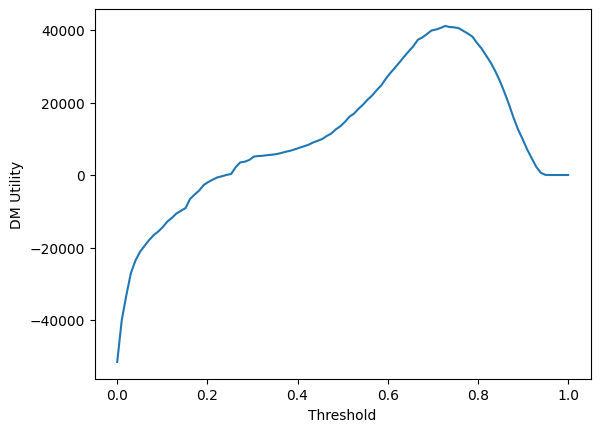

In [ ]:
import matplotlib.pyplot as plt

def plot_dm_utility(y_true, y_pred, thresholds, alpha=1):
    """
    Plot DM utility as a function of threshold
    """
    utilities = [calculate_dm_utility(y_true, y_pred, t, alpha=alpha) for t in thresholds]
    plt.plot(thresholds, utilities)
    plt.xlabel('Threshold')
    plt.ylabel('DM Utility')
    plt.show()

def find_optimal_threshold(y_true, y_pred, thresholds, alpha=1):
    """
    Find the threshold that maximizes DM utility
    """
    utilities = [calculate_dm_utility(y_true, y_pred, t, alpha=alpha) for t in thresholds]
    optimal_idx = np.argmax(utilities)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Set up data
deployment_year = 2014
deployment_horizon = '1-Year'
deployment_state = 'CA'
data_source_deploy = ACSDataSource(survey_year=deployment_year, horizon=deployment_horizon, survey='person')
acs_deploy = data_source_deploy.get_data(states=[deployment_state], download=True)
features_deploy, label_deploy, group_deploy = ACSEmployment.df_to_numpy(acs_deploy)

# Make predictions
yhat_deploy = model.predict(features_deploy)
scores_deploy = model.predict_proba(features_deploy)[:,1]

# Find optimal threshold
thresholds = np.linspace(0, 1, 100)
optimal_threshold = find_optimal_threshold(label_deploy, scores_deploy, thresholds)
print(f"Optimal DM threshold: {optimal_threshold:.3f}")

# Plot DM utility as a function of threshold
plot_dm_utility(label_deploy, scores_deploy, thresholds)


In [ ]:
def demographic_parity_difference(y_true, y_pred, group):
    """
    Calculate the difference in acceptance rates between the two groups
    """
    accept_rate_group1 = np.mean(y_pred[group == 1])
    accept_rate_group2 = np.mean(y_pred[group == 2])
    return accept_rate_group1 - accept_rate_group2

def calculate_fairness_criteria(y_true, y_pred, group, alpha=1):
    """
    Calculate the DM utility and fairness criterion for a given threshold and group
    """
    dm_utility_group1 = calculate_dm_utility(y_true[group == 1], y_pred[group == 1], optimal_threshold, alpha)
    dm_utility_group2 = calculate_dm_utility(y_true[group == 2], y_pred[group == 2], optimal_threshold, alpha)
    dp_diff = demographic_parity_difference(y_true, y_pred, group)
    return dm_utility_group1 + dm_utility_group2 + alpha * np.abs(dp_diff)

def find_optimal_threshold(y_true, scores, group):
    """
    Find the optimal threshold that maximizes DM utility
    """
    thresholds = np.arange(0, 1.1, 0.1)
    dm_utilities = []
    for threshold in thresholds:
        dm_utility = calculate_dm_utility(y_true, scores, threshold)
        dm_utilities.append(dm_utility)
    optimal_threshold = thresholds[np.argmax(dm_utilities)]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(label_deploy, scores_deploy, group_deploy)
fairness_criteria = calculate_fairness_criteria(label_deploy, scores_deploy, group_deploy)
dp_diff = demographic_parity_difference(label_deploy, yhat_deploy, group_deploy)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Fairness criterion: {fairness_criteria:.2f}")
print(f"Demographic parity difference: {dp_diff:.2f}")

Optimal threshold: 0.70
Fairness criterion: 39819.14
Demographic parity difference: 0.20
